## Dependencies

In [ ]:
!pip install feature_engine

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from imblearn.pipeline import make_pipeline as imblearn_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# load the dataset
df = pd.read_csv("./cleaned_online_shoppers_intention.csv")
df = df.drop(['operating_systems', 'browser', 'region', 'traffic_type'], axis=1)
df.sample()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,visitor_type,weekend,revenue,avg_adm_duration_per_page,avg_inf_duration_per_page,avg_prod_duration_per_page
8460,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Q4,Returning_Visitor,0,0,0.0,0.0,0.0


## Visualization

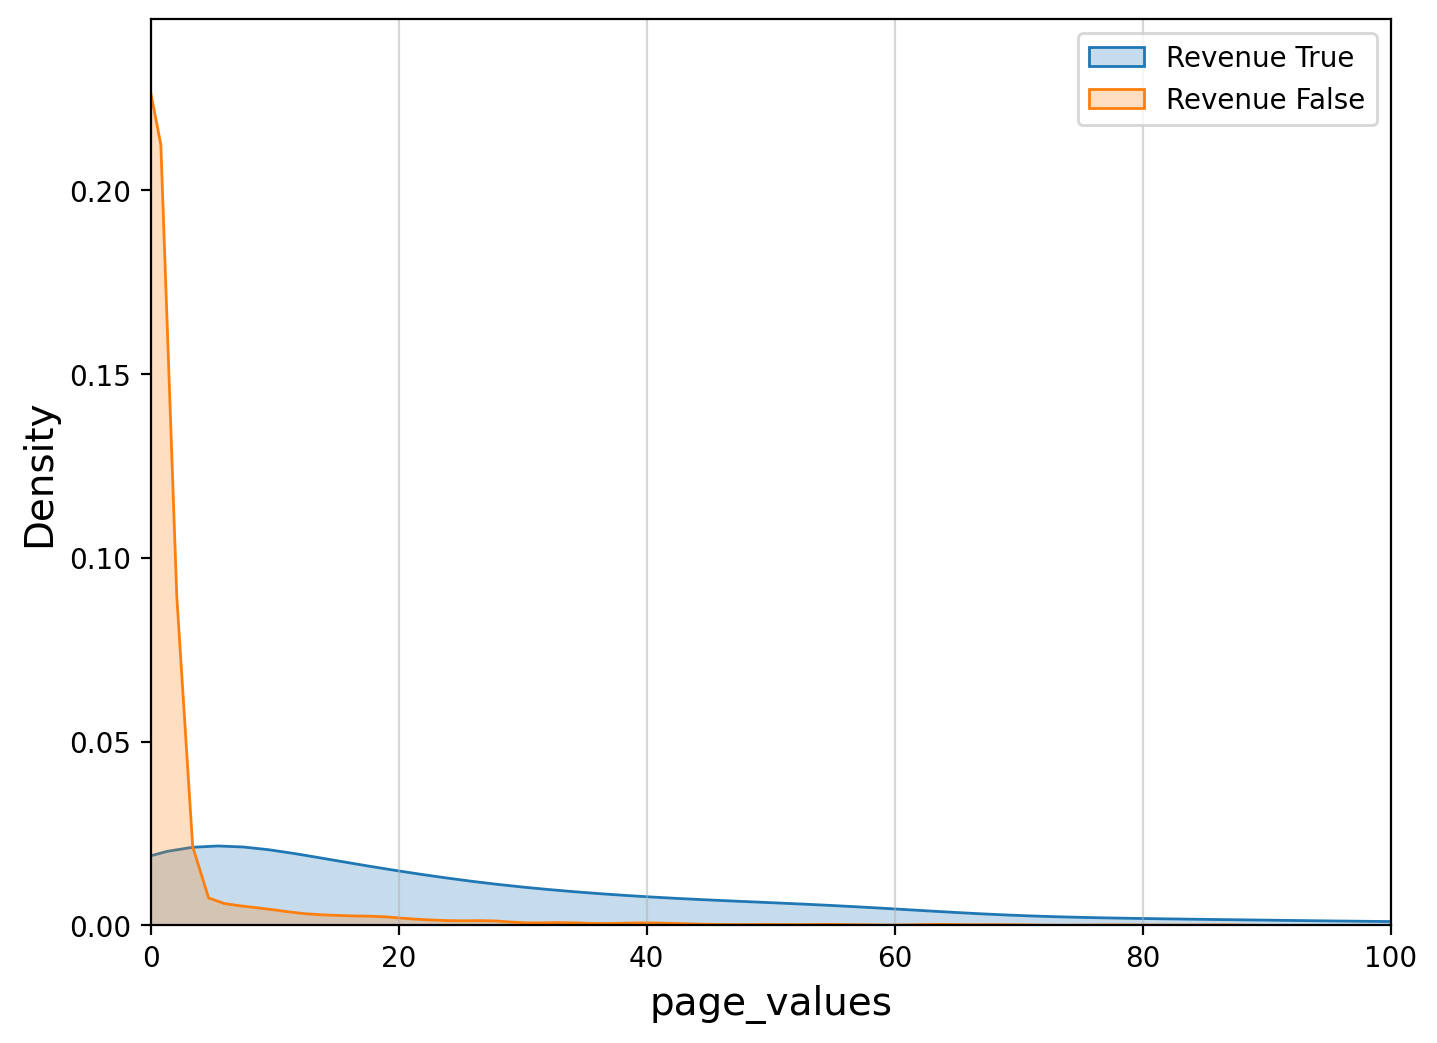

In [ ]:
# kdeplot
col = 'page_values'
group_true = df[df['revenue'] == 1].copy()
group_false = df[df['revenue'] == 0].copy()

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

sns.kdeplot(group_true[col], ax=ax, label='Revenue True', shade='#D53E4F')
sns.kdeplot(group_false[col], ax=ax, label='Revenue False', shade='#99d594')

plt.xlabel(col, fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='x', alpha=0.5)
plt.legend()
plt.xlim([0, 100])
plt.show()

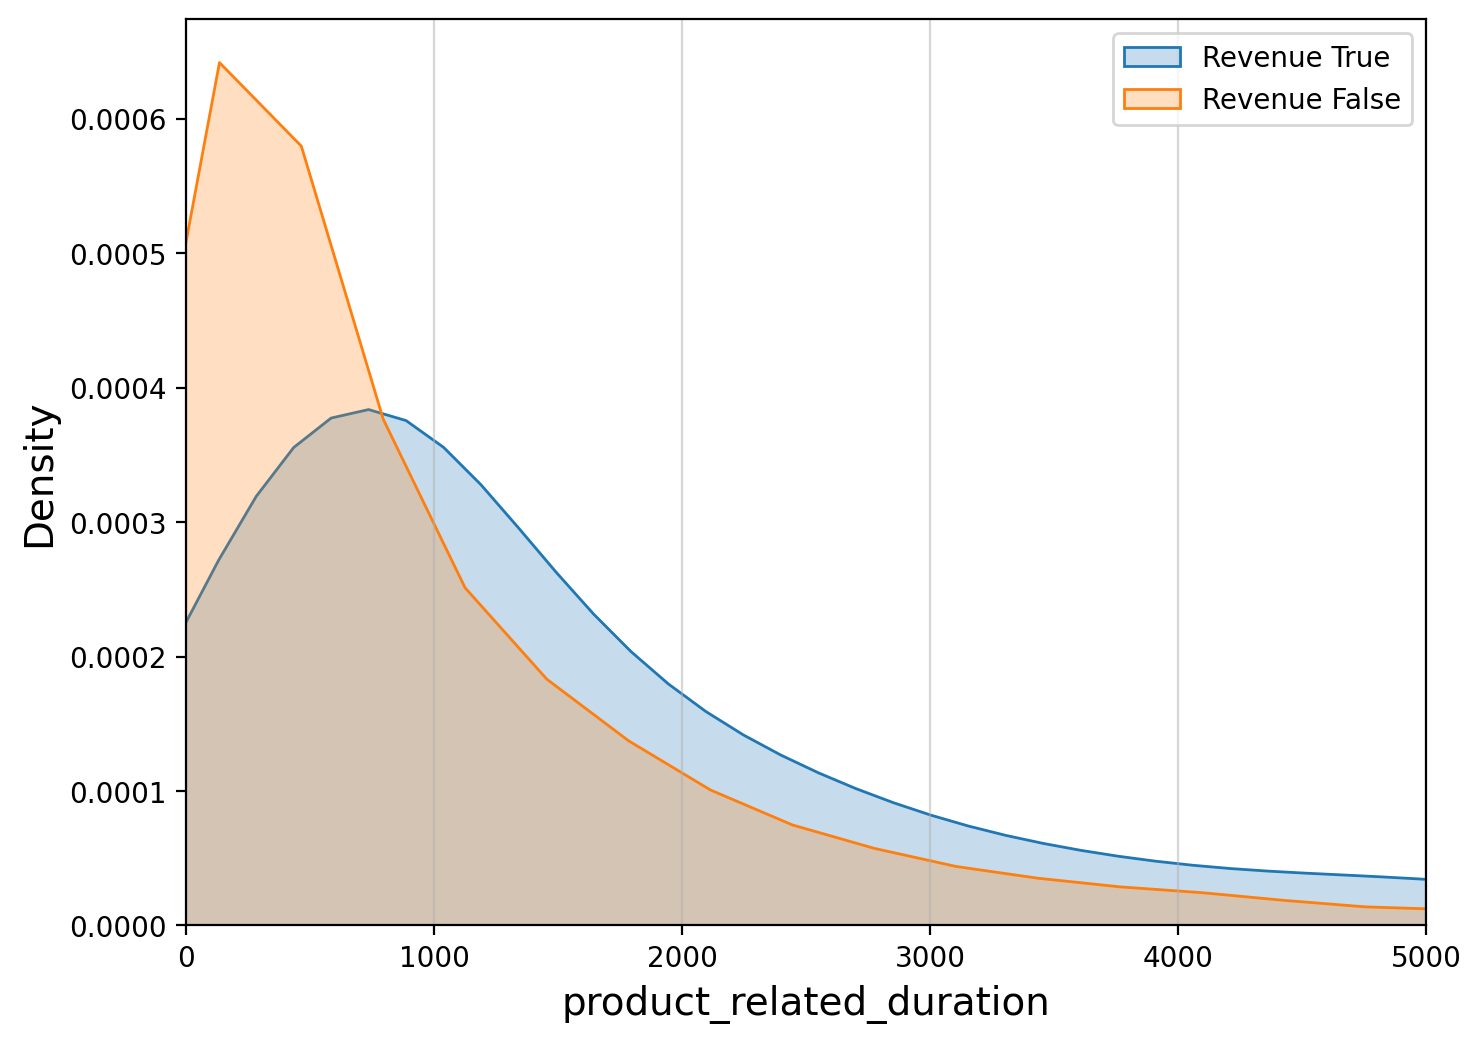

In [ ]:
# kdeplot
col = 'product_related_duration'
group_true = df[df['revenue'] == 1].copy()
group_false = df[df['revenue'] == 0].copy()

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

sns.kdeplot(group_true[col], ax=ax, label='Revenue True', shade='#D53E4F')
sns.kdeplot(group_false[col], ax=ax, label='Revenue False', shade='#99d594')

plt.xlabel(col, fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='x', alpha=0.5)
plt.legend()
plt.xlim([0, 5000])
plt.show()

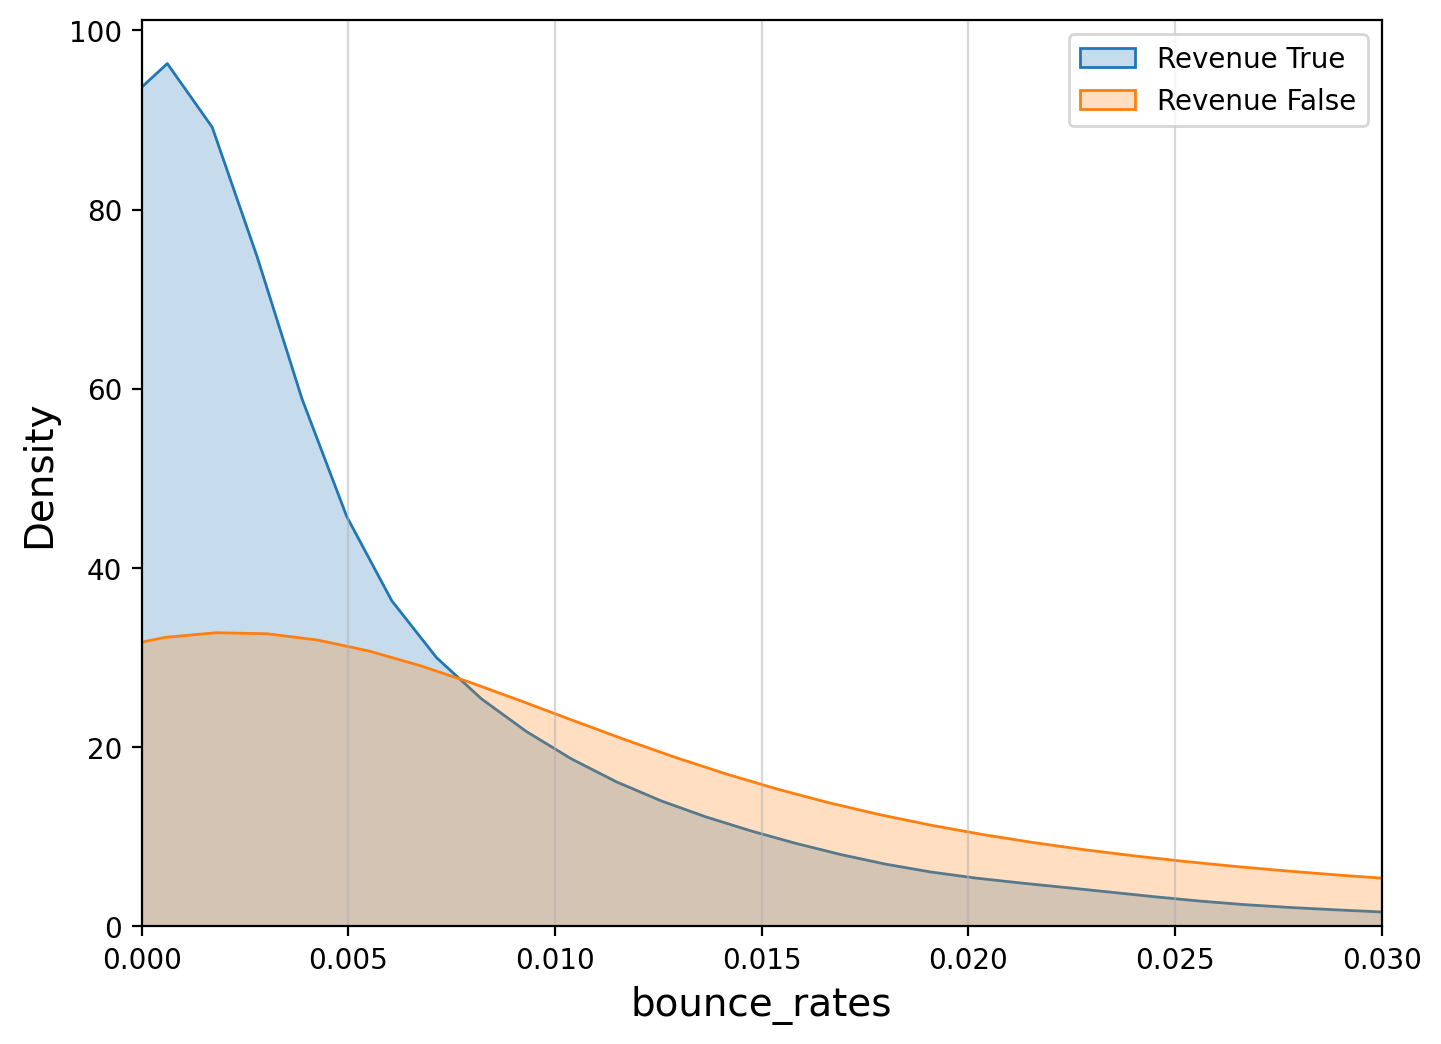

In [ ]:
# kdeplot
col = 'bounce_rates'
group_true = df[df['revenue'] == 1].copy()
group_false = df[df['revenue'] == 0].copy()

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

sns.kdeplot(group_true[col], ax=ax, label='Revenue True', shade='#D53E4F')
sns.kdeplot(group_false[col], ax=ax, label='Revenue False', shade='#99d594')

plt.xlabel(col, fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='x', alpha=0.5)
plt.legend()
plt.xlim([0, 0.03])
plt.show()

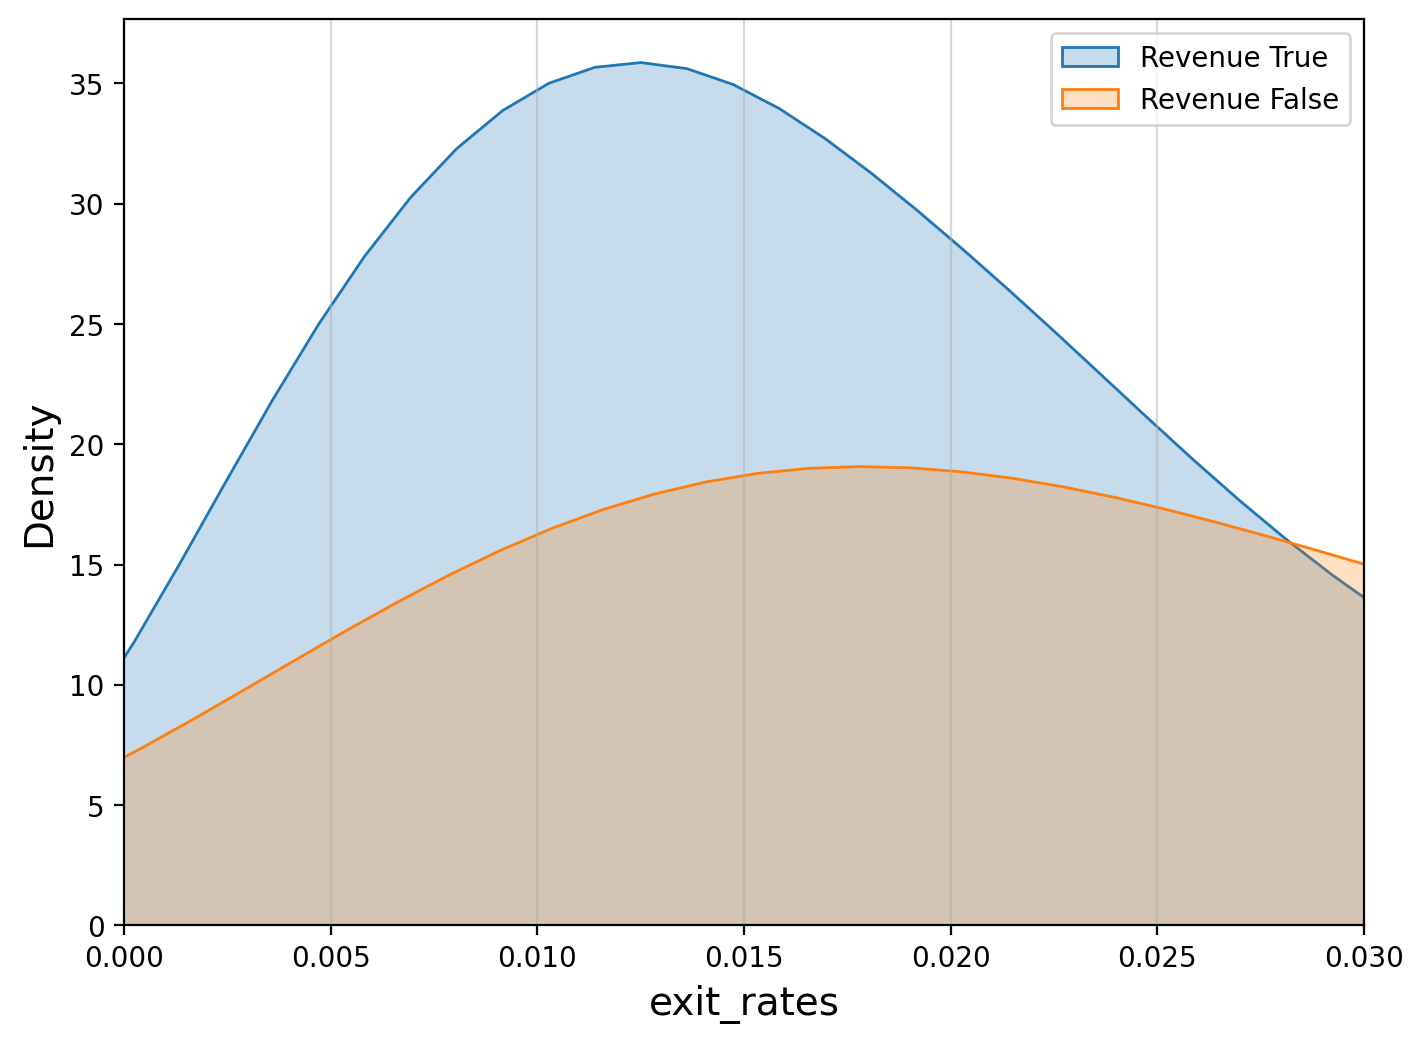

In [ ]:
# kdeplot
col = 'exit_rates'
group_true = df[df['revenue'] == 1].copy()
group_false = df[df['revenue'] == 0].copy()

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

sns.kdeplot(group_true[col], ax=ax, label='Revenue True', shade='#D53E4F')
sns.kdeplot(group_false[col], ax=ax, label='Revenue False', shade='#99d594')

plt.xlabel(col, fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='x', alpha=0.5)
plt.legend()
plt.xlim([0, 0.03])
plt.show()

## Preprocessing

In [3]:
# set up the validation framework
full_train, test = train_test_split(
    df,
    test_size=0.2,
    random_state=0,
    stratify=df['revenue']
)

# features matrices and target vectors
X_train = full_train.drop('revenue', axis=1)
y_train = full_train['revenue']

X_test = test.drop('revenue', axis=1)
y_test= test['revenue']

# data preprocessing
one_hot_enc = OneHotEncoder(variables=['month', 'visitor_type'])
X_train = one_hot_enc.fit_transform(X_train)
X_test = one_hot_enc.transform(X_test)

## 1. Simulasi kenaikan purchase rate

Insight yang diperoleh dari feature importance model dapat digunakan untuk menghitung simulasi peningkatkan purchase rate. Sebagai contoh, Page Values akan digunakan sebagai feature untuk melakukan simulasi. Berdasarkan Partial Dependence Plot dibawah ini, kenaikan jumlah halaman yang dikunjungi oleh visitor sebandingkan dengan kenaikan peluang seorang visitor untuk membeli.

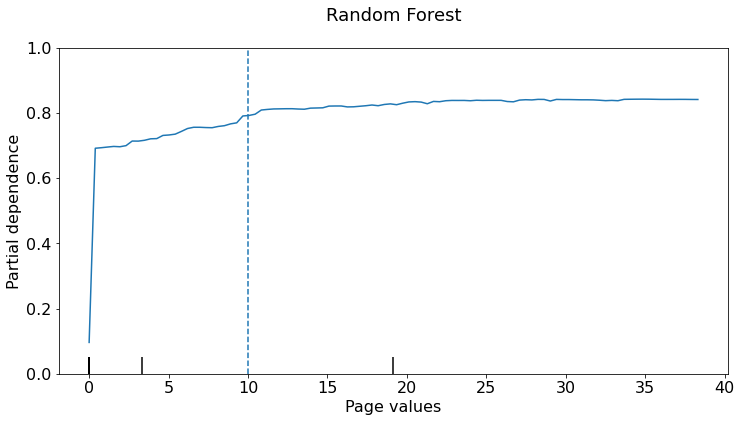

In [ ]:
# select feature based on feature importance and assume there is no multicollinear features present
selected_features = ['page_values', 'exit_rates', 'month_Q2', 'product_related_duration', 'administrative_duration']
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# re-train the model
rf_balanced = RandomForestClassifier(random_state=0, max_depth=7, class_weight='balanced_subsample')
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    rf_balanced
)
model.fit(X_train_sel, y_train)

# show the partial dependence plot
clf = model[-1]
X = pd.concat([X_train_sel, X_test_sel])
feature_to_show = ["page_values"]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Random Forest\n", fontsize=18)
pdp_display = PartialDependenceDisplay.from_estimator(clf, X, feature_to_show, ax=ax)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Page values", fontsize=16)
plt.ylabel("Partial dependence", fontsize=16)
plt.ylim([0, 1])
#plt.xlim([0, 20])
plt.axvline(10, linestyle='--')
plt.show()

Data test set dengan jumlah visitor sebanyak 2441 orang akan dipisah berdasarkan label revenue. Karena target kami adalah visitor yang tidak membeli (revenue False), maka jumlah visitor yang akan diberi treatment berupa voucher per kategori barang sebanyak 2059 orang. Dengan asumsi setelah diberi treatment dan menggunakan acuan dari Partial Dependence Plot, visitor akan banyak melakukan browsing di e-commerce sehingga jumlah page values meningkat menjadi 10 pages. Hasil simulasi perhitungan kenaikan purchase sebagai berikut.

In [ ]:
# modeling
rf_balanced = RandomForestClassifier(random_state=0, max_depth=7, class_weight='balanced_subsample')
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    rf_balanced
)
model.fit(X_train, y_train)

# modified test data
X_test_new = X_test.copy()
X_test_new['revenue'] = y_test.copy()

# select the threshold based on PDP
page_values_threshold = 10

# change the page_values data for page_values <= 5
filter_for_revenue_false = X_test_new['revenue'] == 0
func = lambda x: page_values_threshold if x <= page_values_threshold else x
X_test_new.loc[filter_for_revenue_false, 'page_values'] = X_test_new.loc[filter_for_revenue_false, 'page_values'].apply(func)

# prediction on test data
y_proba = model.predict_proba(X_test_new.drop('revenue', axis=1))[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# calculate convert visitors
total_treated_visitors = X_test[filter_for_revenue_false].shape[0]
potential_convert_visitors = ((X_test_new['revenue'] == 0) & (y_pred == 1)).sum()
purchase_rate_after_treatment = potential_convert_visitors * 100 / X_test_new.shape[0]

# display the results
print(f"Page values threshold: {page_values_threshold}")
print(f"Total visitors who get a treatment: {total_treated_visitors} visitors")
print(f"Convert-to-purchase visitors after get a treatment: {potential_convert_visitors} visitors")
print(f"Purchase Rate After Treatment: {purchase_rate_after_treatment:.2f}%")

Page values threshold: 10
Total visitors who get a treatment: 2059 visitors
Convert-to-purchase visitors after get a treatment: 1849 visitors
Purchase Rate After Treatment: 75.75%


## 2. Feature Importance

In [ ]:
def show_feature_importance(model, features):
    feat_importances = pd.Series(model.feature_importances_, index=features)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Feature Importance Score\n', fontsize=18)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

tuned_model = {
 'ExtraTreesClassifier': ExtraTreesClassifier(
    criterion='entropy', max_depth=34, min_samples_split=29,
    n_estimators=349, random_state=0),

 'RandomForestClassifier': RandomForestClassifier(
    max_depth=40, min_samples_split=17, n_estimators=108,
    random_state=0),

 'XGBClassifier': XGBClassifier(
    colsample_bytree=0.6, learning_rate=0.001005714700171731,
    max_depth=35, min_child_weight=13, n_estimators=337,
    reg_alpha=0.1, reg_lambda=0.00019766276396399466,
    scale_pos_weight=0.1, subsample=0.7)
}

### Random Forest

 **Before tuning**

Train set
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      8238
           1       0.62      0.80      0.70      1526

    accuracy                           0.89      9764
   macro avg       0.79      0.86      0.82      9764
weighted avg       0.91      0.89      0.90      9764

Test set
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2059
           1       0.62      0.78      0.69       382

    accuracy                           0.89      2441
   macro avg       0.79      0.85      0.81      2441
weighted avg       0.90      0.89      0.89      2441



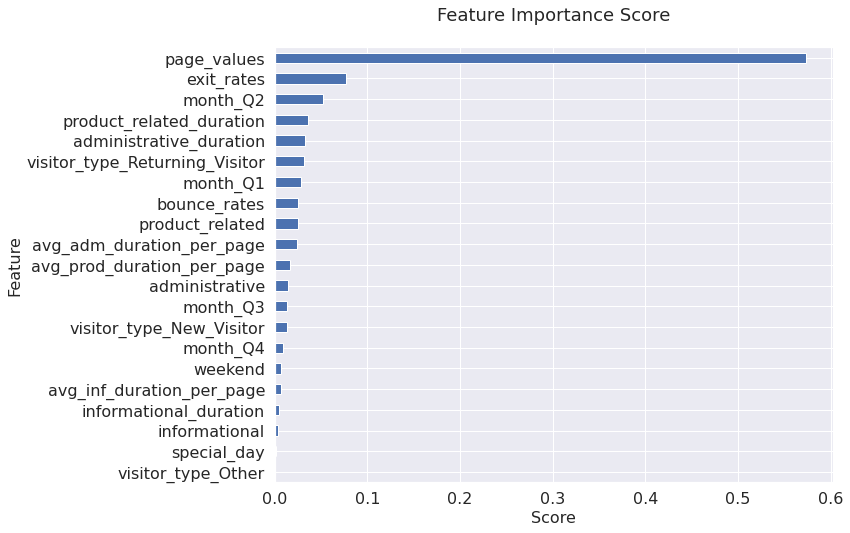

In [ ]:
clf = RandomForestClassifier(
  random_state=0,
  max_depth=7,
  class_weight="balanced_subsample"
)
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)

# prediction on train data
y_pred = model.predict(X_train)
print("Train set")
print(classification_report(y_train, y_pred))

# prediction on test data
y_pred = model.predict(X_test)
print("Test set")
print(classification_report(y_test, y_pred))

# feature importance plot
sns.set(font_scale=1) 
show_feature_importance(model[-1], X_test.columns)

 **After tuning**

Train set
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8238
           1       0.80      0.85      0.82      1526

    accuracy                           0.94      9764
   macro avg       0.88      0.90      0.89      9764
weighted avg       0.94      0.94      0.94      9764

Test set
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2059
           1       0.64      0.68      0.66       382

    accuracy                           0.89      2441
   macro avg       0.79      0.81      0.80      2441
weighted avg       0.89      0.89      0.89      2441



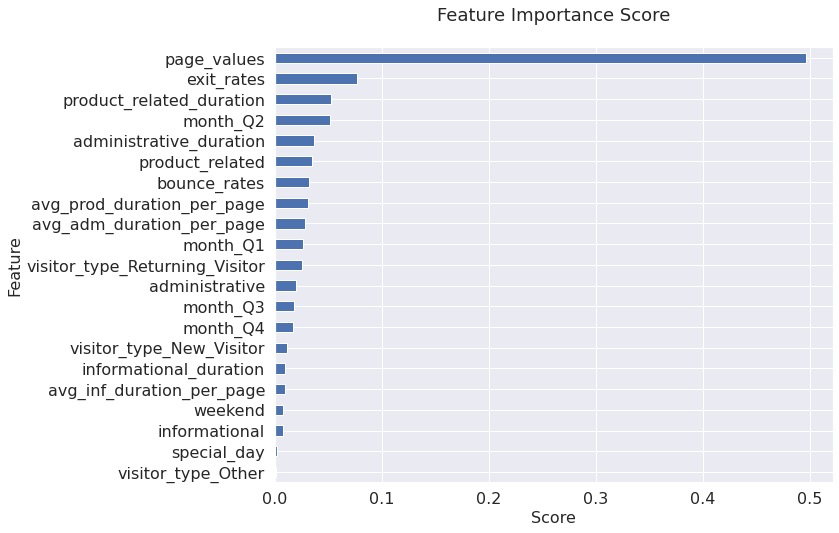

In [ ]:
clf = tuned_model['RandomForestClassifier']
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)

# prediction on train data
y_pred = model.predict(X_train)
print("Train set")
print(classification_report(y_train, y_pred))

# prediction on test data
y_pred = model.predict(X_test)
print("Test set")
print(classification_report(y_test, y_pred))

# feature importance plot
sns.set(font_scale=1) 
show_feature_importance(model[-1], X_test.columns)

### Extra Trees

**Before Tuning**

Train set
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      8238
           1       0.36      0.56      0.44      1526

    accuracy                           0.77      9764
   macro avg       0.63      0.69      0.65      9764
weighted avg       0.82      0.77      0.79      9764

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      2059
           1       0.36      0.53      0.43       382

    accuracy                           0.78      2441
   macro avg       0.63      0.68      0.64      2441
weighted avg       0.82      0.78      0.79      2441



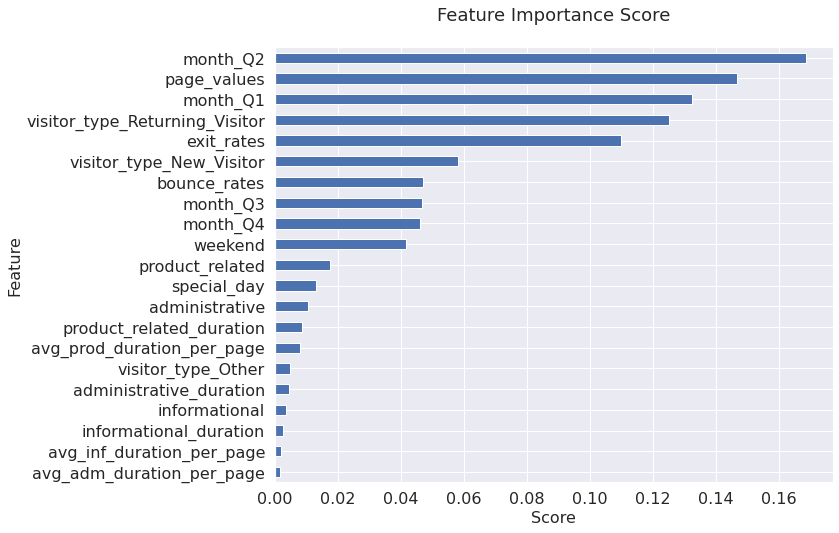

In [ ]:
clf = ExtraTreesClassifier(
  random_state=0,
  max_depth=7,
  class_weight="balanced_subsample"
)
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)

# prediction on train data
y_pred = model.predict(X_train)
print("Train set")
print(classification_report(y_train, y_pred))

# prediction on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# feature importance plot
sns.set(font_scale=1) 
show_feature_importance(model[-1], X_test.columns)

**After Tuning**

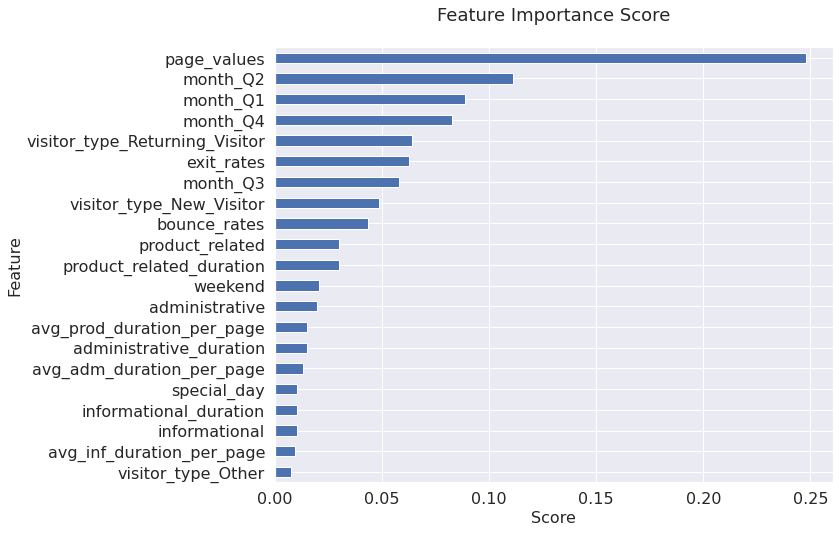

In [ ]:
clf = tuned_model['ExtraTreesClassifier']
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)

# prediction on train data
y_pred = model.predict(X_train)
print("Train set")
print(classification_report(y_train, y_pred))

# prediction on test data
y_pred = model.predict(X_test)
print("Test set")
print(classification_report(y_test, y_pred))

# feature importance plot
sns.set(font_scale=1) 
show_feature_importance(model[-1], X_test.columns)

### XGBoost

**Before tuning**

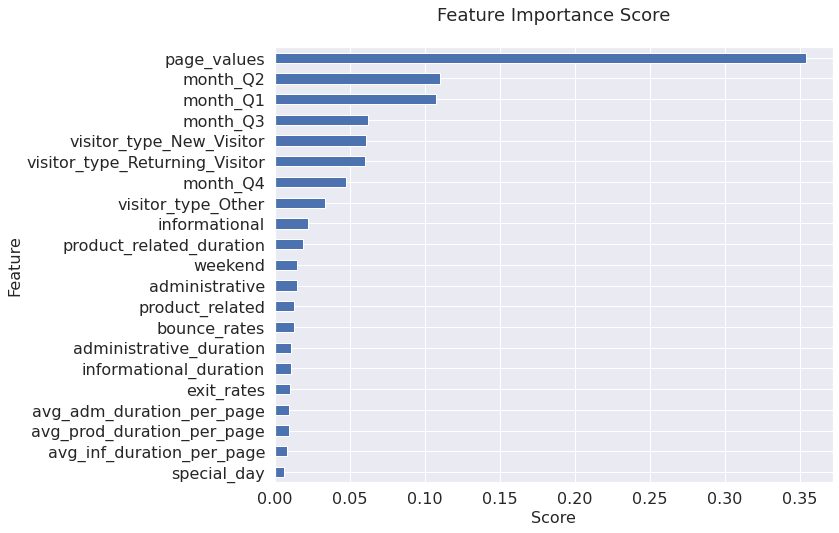

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    random_state=0,
    n_jobs=-1,
    max_depth=7,
    scale_pos_weight=2
)
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)

# prediction on train data
y_pred = model.predict(X_train)
print("Train set")
print(classification_report(y_train, y_pred))

# prediction on test data
y_pred = model.predict(X_test)
print("Test set")
print(classification_report(y_test, y_pred))

# feature importance plot
sns.set(font_scale=1) 
show_feature_importance(model[-1], X_test.columns)

**After tuning**

Train set
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8238
           1       0.97      0.08      0.15      1526

    accuracy                           0.86      9764
   macro avg       0.91      0.54      0.54      9764
weighted avg       0.87      0.86      0.80      9764

Test set
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2059
           1       1.00      0.05      0.10       382

    accuracy                           0.85      2441
   macro avg       0.93      0.53      0.51      2441
weighted avg       0.87      0.85      0.79      2441



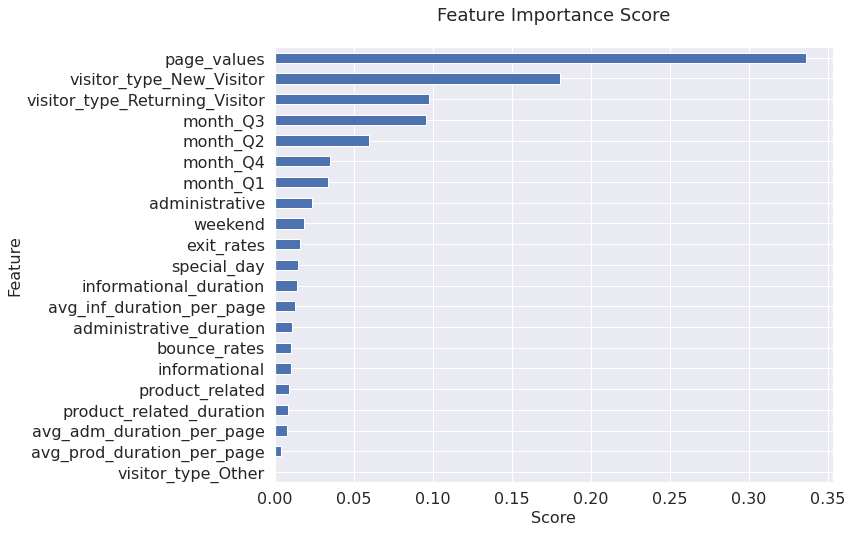

In [ ]:
clf = tuned_model['XGBClassifier']
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)

# prediction on train data
y_pred = model.predict(X_train)
print("Train set")
print(classification_report(y_train, y_pred))

# prediction on test data
y_pred = model.predict(X_test)
print("Test set")
print(classification_report(y_test, y_pred))

# feature importance plot
sns.set(font_scale=1) 
show_feature_importance(model[-1], X_test.columns)

## 3. AUC

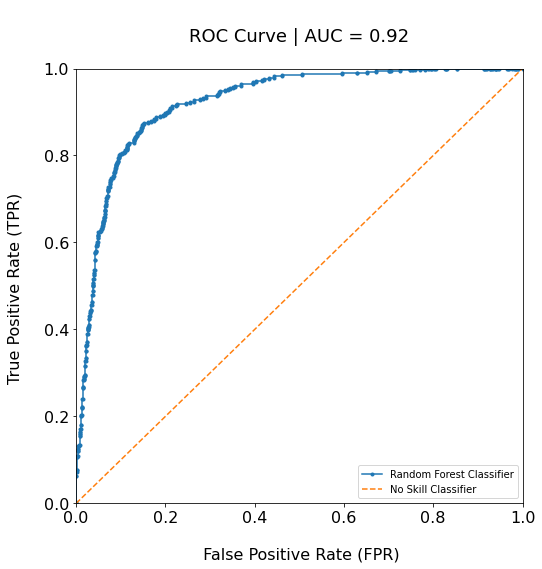

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf = RandomForestClassifier(
  random_state=0,
  max_depth=7,
  class_weight="balanced_subsample"
)
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)

# prediction on test data
y_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)

# fpr vs tpr curve 
fpr, tpr, threshold = roc_curve(y_test, y_proba)

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(fpr, tpr, marker='.', label='Random Forest Classifier')
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill Classifier')

ax.set_title(f"\nROC Curve | AUC = {auc:.2f}\n", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("\n False Positive Rate (FPR)", fontsize=16)
plt.ylabel("True Positive Rate (TPR) \n", fontsize=16)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend()
plt.show()

In [41]:
df_roc = pd.DataFrame()
df_roc['threshold'] = 1 - threshold
df_roc['tpr'] = tpr
df_roc['fpr'] = fpr
pd.set_option("display.precision", 3)
df_roc.sample(10, random_state=0).sort_values(by='threshold').reset_index(drop=True)

,threshold,tpr,fpr
0,0.146,0.110,0.002
1,0.158,0.154,0.009
2,0.329,0.649,0.061
3,0.377,0.702,0.068
4,0.611,0.819,0.114
5,0.704,0.859,0.146
6,0.826,0.963,0.369
7,0.839,0.971,0.403
8,0.958,1.000,0.801
9,0.990,1.000,0.938


## 4. Confusion Matrix

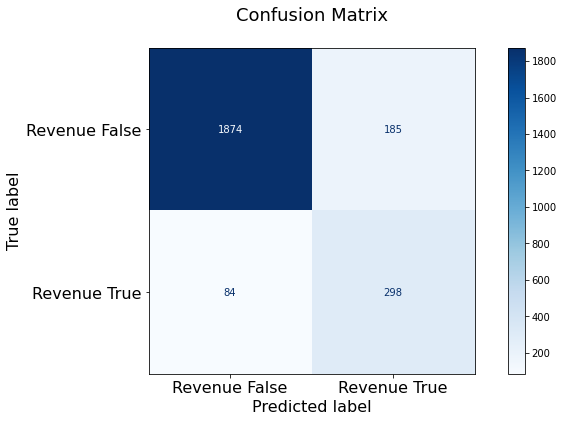

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = RandomForestClassifier(
  random_state=0,
  max_depth=7,
  class_weight="balanced_subsample"
)
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)

# show confusion matrix
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Confusion Matrix\n", fontsize=18)
disp = ConfusionMatrixDisplay.from_estimator(
    model[-1], X_test, y_test, 
    ax=ax, display_labels=['Revenue False', 'Revenue True'],
    cmap=plt.cm.Blues,
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Predicted label", fontsize=16)
plt.ylabel("True label", fontsize=16)
plt.show()